In [7]:
import pickle
trump_data = pickle.load(open("TRUMP_SNIPPETS_DF.pickle", "rb" ))
obama_data = pickle.load(open("OBAMA_SNIPPETS_DF.pickle", "rb" ))

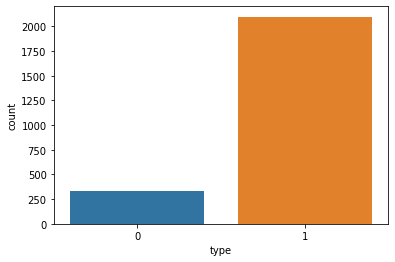

In [8]:
import seaborn as sns
sns.countplot(x='type', data=trump_data)

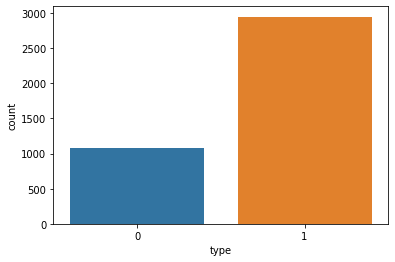

In [9]:
sns.countplot(x='type', data=obama_data)

In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
class Metrics:
    def __init__(self, df):
        self.df = pd.read_pickle(df)
        self.union_speeches = []
        self.rally_speeches = []
        
    def find_avg_word_length(self):
        average_res = []
        rally = self._get_speeches_list_from_df(self.df,1)
        union = self._get_speeches_list_from_df(self.df,0)
        self.rally_speeches.append(rally)
        self.union_speeches.append(union)
        word_count = 0
        total_characters = 0
        for speech_list in [rally, union]:
            for speech in speech_list:
                word_count += len(speech.split())
                total_characters += len(speech) - speech.count(' ')
                
            avg_word_length = total_characters / word_count
            average_res.append(round(avg_word_length,2))
            
            
        return average_res


    def _get_speeches_list_from_df(self, df, attr_val):
        df_speeches = df.loc[df['type'] == attr_val]
        speeches_list = df_speeches['transcript'].tolist()

        return speeches_list

In [ ]:
trump_snippits = Metrics("TRUMP_SNIPPETS_DF.pickle")
trump_speeches = Metrics('trump_speeches_df.pickle')
obama_speeches = Metrics('obama_speeches_df.pickle')
obama_snippits = Metrics('OBAMA_SNIPPETS_DF.pickle')


print(trump_snippits.find_avg_word_length(), trump_speeches.find_avg_word_length())
print(obama_snippits.find_avg_word_length(), obama_speeches.find_avg_word_length())

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
from nltk.tokenize import word_tokenize

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
class Compress:
    def save_as_npz(self,df,npz_name=None,tran_data='transcript',label='type'):
        X = []
        y = np.array(df[label])
        sentences = np.array(df[tran_data])
        for sen in sentences:
            X.append(preprocess_text(sen))
                        
        self._train_test_split(np.array([X]).T, np.array(y), npz_filename=npz_name)
        
        

    def _train_test_split(self,X,y,npz_filename=''+'.npz',test_size=0.2, random_state=42):
        sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
        sss.get_n_splits(np.array(X), y)
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        tokenizer = Tokenizer(num_words=5000)
        tokenizer.fit_on_texts(X_train.ravel())
        X_train = tokenizer.texts_to_sequences(X_train.ravel())
        X_test = tokenizer.texts_to_sequences(X_test.ravel())
        
        vocab_size = len(tokenizer.word_index) + 1

        maxlen = 100

        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
        
        embeddings_dictionary = dict()
        glove_file = open('glove.6B.50d.txt', encoding="utf8")

        for line in glove_file:
            records = line.split()
            word = records[0]
            vector_dimensions = asarray(records[1:], dtype='float32')
            embeddings_dictionary [word] = vector_dimensions
        glove_file.close()
        embedding_matrix = zeros((vocab_size, 50))
        for word, index in tokenizer.word_index.items():
            embedding_vector = embeddings_dictionary.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        
        np.savez_compressed(npz_filename,
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        vocab_size=vocab_size, 
                        embedding_matrix=embedding_matrix)
        print("Saved {} as .npz".format(npz_filename))
    

In [ ]:
compress = Compress()
compress.save_as_npz(trump_data, npz_name='TrumpSplitData')
compress.save_as_npz(obama_data, npz_name='ObamaSplitData')

In [5]:
import numpy as np
class load_file:
    def __init__(self, file):
        self.file = file

    def get_data(self):
        hal = np.load(self.file)
        X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = [hal[f] for f in hal.files]
        return X_train, y_train, X_test, y_test,vocab_size, embedding_matrix


df = load_file('ObamaSplitData.npz')
X_train, y_train, X_test, y_test,vocab_size, embedding_matrix = df.get_data()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           312300    
_________________________________________________________________
dense_17 (Dense)             (None, 100, 64)           3264      
_________________________________________________________________
dropout_15 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 100, 64)           4160      
_________________________________________________________________
dropout_16 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 100, 32)           2080      
_________________________________________________________________
dropout_17 (Dropout)         (None, 100, 32)          

/home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2013 samples, validate on 2014 samples
Epoch 1/200
2013/2013 [==============================] - 1s 451us/step - loss: 262.1441 - acc: 0.7109 - val_loss: 127.9799 - val_acc: 0.7324
Epoch 2/200
2013/2013 [==============================] - 0s 204us/step - loss: 84.1580 - acc: 0.7298 - val_loss: 45.7839 - val_acc: 0.7324
Epoch 3/200
2013/2013 [==============================] - 0s 194us/step - loss: 34.7174 - acc: 0.7322 - val_loss: 21.5898 - val_acc: 0.7324
Epoch 4/200
2013/2013 [==============================] - 0s 193us/step - loss: 18.4215 - acc: 0.7322 - val_loss: 12.3863 - val_acc: 0.7324
Epoch 5/200
2013/2013 [==============================] - 0s 202us/step - loss: 11.4850 - acc: 0.7322 - val_loss: 7.9885 - val_acc: 0.7324
Epoch 6/200
2013/2013 [==============================] - 0s 200us/step - loss: 7.8690 - acc: 0.7322 - val_loss: 5.6102 - val_acc: 0.7324
Epoch 7/200
2013/2013 [==============================] - 0s 194us/step - loss: 5.7728 - acc: 0.7322 - val_loss: 4.1647 

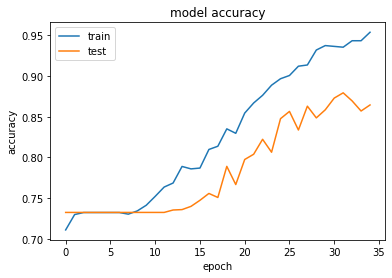

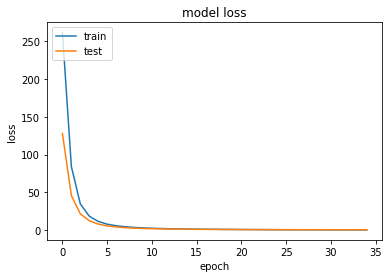

2013/2013 [==============================] - 0s 73us/step
Training Accuracy is 98.11227321624756
2014/2014 [==============================] - 0s 75us/step
Testing Accuracy is 86.44488453865051 


In [6]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense
from keras.constraints import max_norm
from keras.regularizers import l1,l2
from keras import optimizers
import keras
maxlen = 100
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen)
model.add(embedding_layer)
model.add(Dense(64, activity_regularizer=l2(0.01), activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))



model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))



model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))



model.add(Dense(128, activation='relu'))
model.add(Dropout(0.6))




model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))



model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(32,activation='relu'))

model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=optimizers.adam(), loss='binary_crossentropy', metrics=['acc'])
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print(model.summary())
history = model.fit(X_train, y_train, batch_size=64, epochs=200, validation_data=(X_test, y_test), callbacks=[es_callback])


import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy is {}'.format(accuracy*100))

loss, accuracy = model.evaluate(X_test,y_test)


print('Testing Accuracy is {} '.format(accuracy*100))